In [5]:
#!pip install scikit-uplift catboost==0.22 -U

In [4]:
#!pip install causalml

- скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention

- там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

- сделать разбиение набора данных не тренировочную и тестовую выборки

- сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)

- провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями

- в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево

- (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion

- (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
data = pd.read_csv('data.csv')

In [9]:
data.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [10]:
data.offer.value_counts()

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: offer, dtype: int64

In [11]:
data.conversion.value_counts()

0    54606
1     9394
Name: conversion, dtype: int64

In [12]:
data.rename(columns={'offer': 'treatment', 'conversion': 'target'}, inplace=True)

In [13]:
data.head(2)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0


No offer - не было коммуникации

Discount - была коммуникация 

Buy one get one - была коммуникация 

In [14]:
data['treatment'] = data['treatment'].replace(
    {'Buy One Get One': 1, 'Discount': 1, 'No Offer': 0})

<AxesSubplot:>

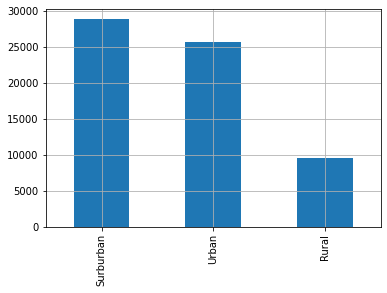

In [17]:
data.zip_code.value_counts().plot(kind = 'bar', grid=True)

In [18]:
data['zip_code'] = data['zip_code'].replace(
    {'Suburban': 1, 'Urban': 2, 'Rural': 3})

<AxesSubplot:>

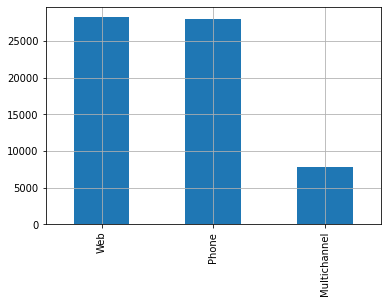

In [19]:
data.channel.value_counts().plot(kind = 'bar', grid=True)

<AxesSubplot:>

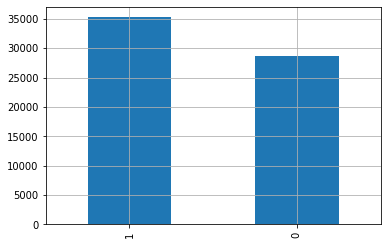

In [20]:
data.used_discount.value_counts().plot(kind = 'bar', grid=True)

<AxesSubplot:>

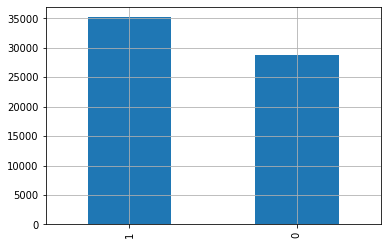

In [21]:
data.used_bogo.value_counts().plot(kind = 'bar', grid=True)

<AxesSubplot:>

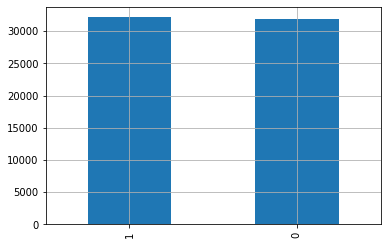

In [23]:
data.is_referral.value_counts().plot(kind = 'bar', grid=True)

<AxesSubplot:>

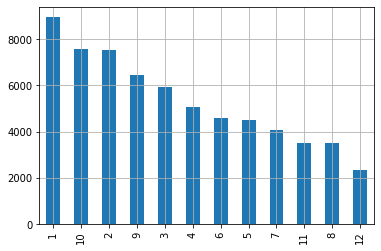

In [24]:
data.recency.value_counts().plot(kind = 'bar', grid=True)

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   treatment      64000 non-null  int64  
 8   target         64000 non-null  int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 4.4+ MB


<AxesSubplot:>

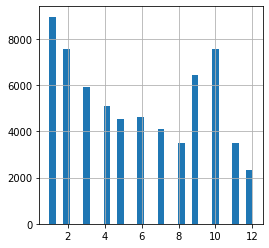

In [30]:
data.loc[:, 'recency'].hist(figsize=(4, 4), bins=30, grid=True)

Применим логарифмическое преобразование, чтобы сделать распределение нормальным. Сдвинем на +1, чтобы избежать логарифм в нуле 

<AxesSubplot:>

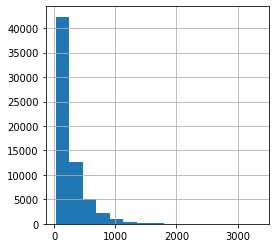

In [32]:
data.loc[:, 'history'].hist(figsize=(4, 4), bins=15, grid=True)

In [33]:
data['history_log'] = np.log(data['history'] + 1.1)

<AxesSubplot:>

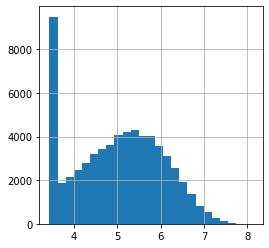

In [40]:
data.loc[:, 'history_log'].hist(figsize=(4, 4), bins=25, grid=True)

Гипотеза: возможно, стоит как-то уменьшить значения самого первого столбца, чтобы нормализовать распределение. 

In [42]:
data.columns.to_list()

['recency',
 'history',
 'used_discount',
 'used_bogo',
 'zip_code',
 'is_referral',
 'channel',
 'treatment',
 'target',
 'history_log']

In [43]:
features = ['recency', 'used_discount', 'used_bogo', 'zip_code', 'is_referral', 'channel', 'treatment',
             'target', 'history_log']

In [44]:
from sklearn.model_selection import train_test_split

In [ ]:
indices_learn, indices_valid = train_test_split(df_train.index, test_size=0.3, random_state=123) # разбили известный набор на 2 части

In [ ]:
# данные для обучения
X_train = df_features.loc[indices_learn, :] # признаки о клиенте (в них остались только описания клиентов )
y_train = df_train.loc[indices_learn, 'target'] #целевой признак (те кто сделал правильное действие)
treat_train = df_train.loc[indices_learn, 'treatment_flg']  #те кому написали смс с предложением
#данные для валидации
X_val = df_features.loc[indices_valid, :]
y_val = df_train.loc[indices_valid, 'target']
treat_val =  df_train.loc[indices_valid, 'treatment_flg']
#весь набор целиком
X_train_full = df_features.loc[indices_train, :]
y_train_full = df_train.loc[:, 'target']
treat_train_full = df_train.loc[:, 'treatment_flg']
#данные из теста (слепые)
X_test = df_features.loc[indices_test, :]
# наш категорийный признак
cat_features = ['gender']
# словарь для записывания результатов
models_results = {
    'approach': [],
    'uplift@30%': []
}